In [1]:
import torch
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as m



In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
from src.data import get_nonlinear_data,hopf
from src.edmd import TruncEDMD, KernelEDMD, DMD 
from src.kernels import  LinearKernel
from src.visualizations import  OOS_tradjectory,legend_without_duplicate_labels,gridsearch,dynamicshopf
from matplotlib.legend_handler import HandlerTuple

In [5]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Plot Original System

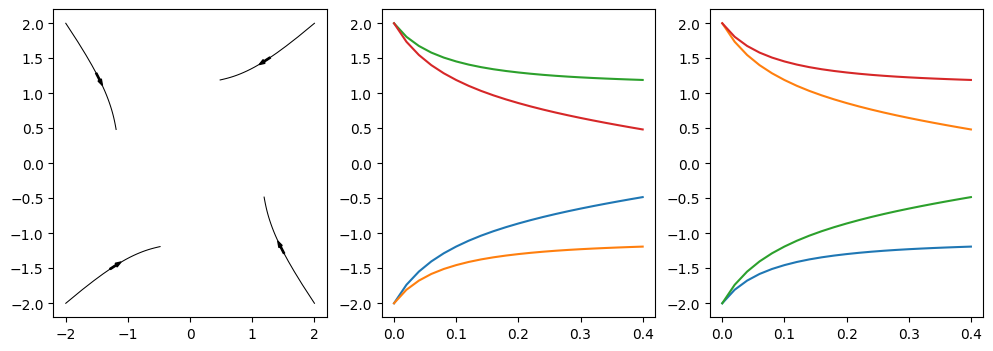

In [10]:
dynamic_system="hopf"
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps=21
t_end=0.4
t_eval=np.linspace(0, t_end, timesteps)
df_Original=pd.DataFrame()
factor=1

initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2,2), np.linspace(-2, 2, 2))).T.reshape(-1, 2)

x = np.zeros((len(initial_conditions)*(timesteps-1), 2))
y = np.zeros((len(initial_conditions)*(timesteps-1), 2))
original= np.zeros((len(initial_conditions)*(timesteps), 2))


x,y,original,t_eval_frac=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)

#plot with arrows
for ic, condition in enumerate(initial_conditions):
   
   
    ax[0].plot(original[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original[ic*(timesteps):ic*(timesteps)+(timesteps), 1],
               color="black",linewidth=0.75)
    x=original[ic*(timesteps)+(timesteps)//5, 0]
    y=original[ic*(timesteps)+(timesteps)//5, 1]
    dx=original[ic*(timesteps)+(timesteps)//5+1, 0]-original[ic*(timesteps)+(timesteps)//5, 0]
    dy=original[ic*(timesteps)+(timesteps)//5+1, 1]-original[ic*(timesteps)+(timesteps)//5, 1]
    ax[0].arrow(x,y,dx,dy,width=0.02,color="black")
    ax[1].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax[2].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 1])
    




Perform Grid Search to find optimal parameters

In [13]:

initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
initial_conditions_sample=np.array([[1.5,1.5],[0.75,0.75],[-.4,-0.4]])
method = TruncEDMD()
parameters = np.array([None]) #None here if no kernel paramters
truncs=np.array([2,3,4,5])#np.array([2,3,4,5,6,7,8,9,10])
#steps=np.arange(100,500,50)
factors=np.arange(1,3,1)#np.arange(1,15,1)
#grid=np.empty(len(factors),len(truncs))
timesteps=40
t_end=0.4#0.0006
kernel = LinearKernel()
index=0

lossperstep,OOSlossperstep,optim=gridsearch(factors,truncs,parameters,initial_conditions,
                                            initial_conditions_sample,timesteps,t_end,method,kernel,hopf)



KeyboardInterrupt: 

Plot the results of the grid search

(array([12], dtype=int64), array([4], dtype=int64))


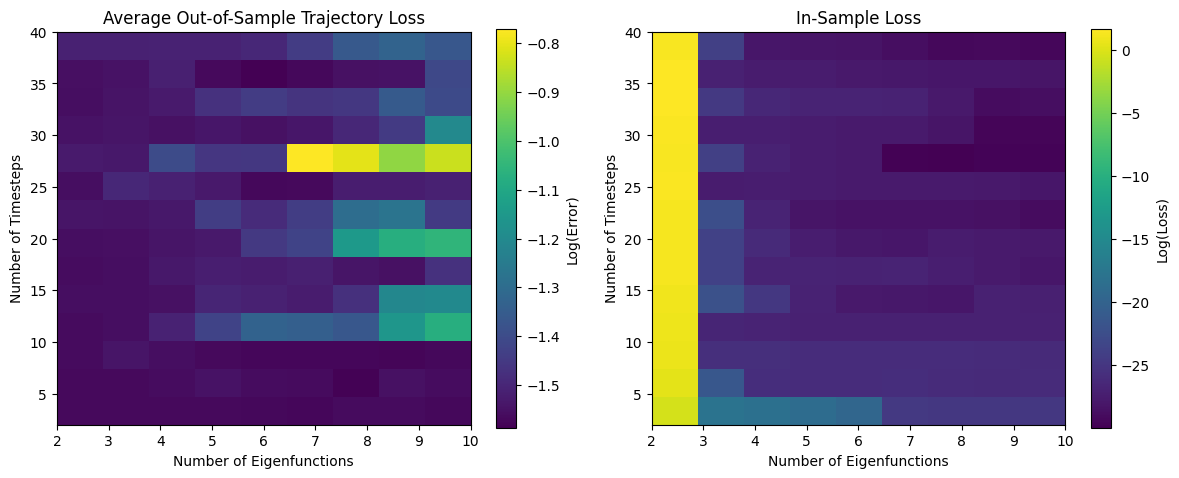

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots

# Plot the first image in the first subplot
im1 = ax[0].imshow(np.log(OOSlossperstep),extent=[2,10,2,40],aspect=0.2,origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0],shrink=0.7)  # Colorbar for the first image
cbar1.set_label("Log(Error)")
ax[0].set_xlabel("Number of Eigenfunctions")
ax[0].set_ylabel("Number of Timesteps")
#ax[0].set_xticks([1,10,21])  # Specify the positions of x-axis ticks
#ax[0].set_yticks(np.arange(1,22,2))

ax[0].set_title("Average Out-of-Sample Trajectory Loss")  # Optionally set a title for the first subplot

# Plot the second image in the second subplot
im2 = ax[1].imshow(np.log(lossperstep),extent=[2,10,2,40],aspect=0.2,origin="lower")
cbar2 = fig.colorbar(im2, ax=ax[1],shrink=0.7)  # Colorbar for the second image
cbar2.set_label("Log(Loss)")
ax[1].set_xlabel("Number of Eigenfunctions")
ax[1].set_ylabel("Number of Timesteps")
ax[1].set_title("In-Sample Loss")  # Optionally set a title for the second subplot

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
min=np.where(optim == np.nanmin(optim))


print(min)

plt.show()


Plot and report the in-sample and out of sample loss for the best paramter combination

tensor(0.0003, dtype=torch.float64)


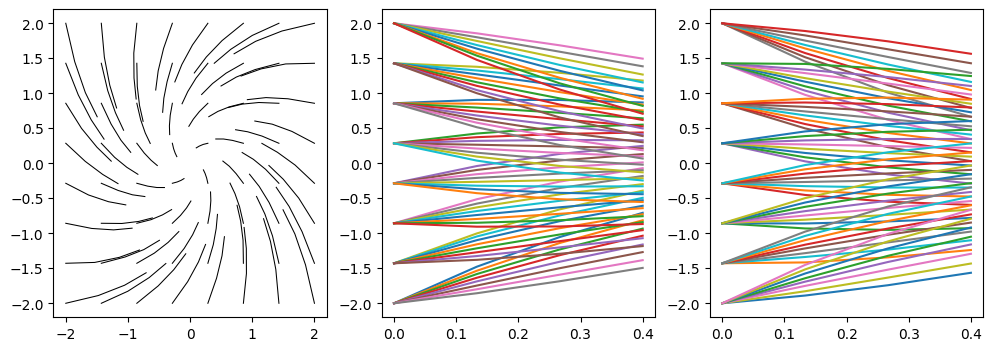

In [15]:

initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
t_end=0.4#0.0006
timesteps=40
dt=t_end/timesteps
t_eval=np.linspace(0, t_end, timesteps)
trunc=3
factor=12 #always Keep the samehere
method = TruncEDMD()
#parameter = torch.tensor(0.4, requires_grad=True)
kernel = LinearKernel()
f, ax = plt.subplots(1, 3, figsize=(12, 4))

x,y,original,t_eval=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)
Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)
method.preloss_computation_full()
loss = method.loss_full(kernel, x.T, y.T, penalty=True)
#in-sample ###########################################################
for ic,condition in enumerate(initial_conditions):

    condition=np.array([condition],ndmin=2)
    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel,Kernel_results) 
    #df=pd.DataFrame(data=Fx, index=t_eval,columns =np.array( ['x1','x2']) )

    ax[0].plot(Fx[:,0],Fx[:,1],color="black",linewidth=0.75)
    ax[1].plot(t_eval,Fx[:,0])
    ax[2].plot(t_eval,Fx[:,1])
    
print(loss)
   


L2_norm 0.9841900484915351


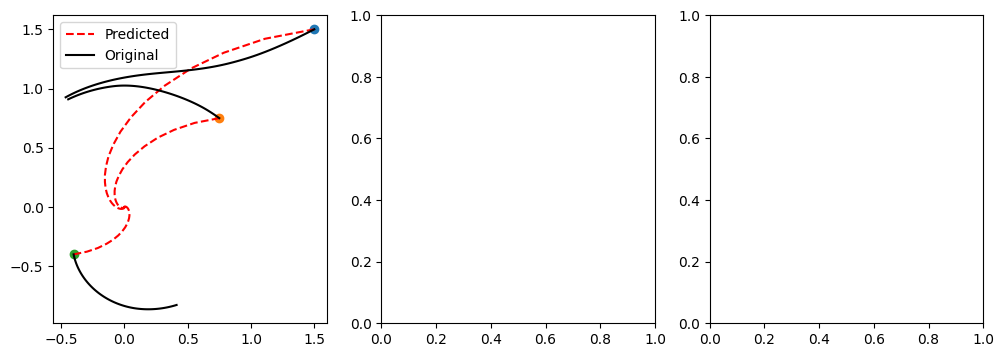

In [16]:

#out of sample #################################################################   
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps_sample=125
t_end_sample =timesteps_sample*dt
t_eval_sample = np.linspace(0, t_end_sample, timesteps_sample)
initial_conditions_sample=np.array([[1.5,1.5],[0.75,0.75],[-.4,-0.4]])

sumloss=0
for ic,condition in enumerate(initial_conditions_sample):
    solution,df=get_nonlinear_data(t_eval_sample,condition,hopf)
        
    condition=np.array([condition],ndmin=2)
 
    predicted=method.single_tradjectory(t_eval_sample,condition.T,x.T,y.T,kernel,Kernel_results)   
    sumloss = sumloss+np.sqrt(np.sum(np.square(predicted-solution))/len(t_eval_sample))
       
    ax[0].plot(predicted[:,0],predicted[:,1],0.1,c="red",linestyle='--', label="Predicted" )   
    ax[0].plot(solution[:,0],solution[:,1],0.1,c="black", label="Original" )  
    ax[0].scatter(condition[:,0],condition[:,1]) 
        
                
    legend_without_duplicate_labels(ax[0])
l2=sumloss/len(initial_conditions_sample)          
#print(predicted)
#Compute Relative L2 Error

print("L2_norm",l2)        